## Assessment of the impact of OCR on linguistic tasks

In particular, in this notebook we're looking at:
- Part-of-speech tagging accuracy (fine- and coarse-grained)
- Named entity recognition accuracy (matching type, matching type and IOB-tag)
    - Persons: f-score (by quality band)
    - Geopolitical entities: f-score (by quality band)
    - Dates: f-score (by quality band)
- Dependency parsing

In [1]:
import spacy
import pandas as pd
import numpy as np
import collections
import re
import ast
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
sampledf = pd.read_pickle("trove_artidigh_aligned_human.pkl")

In [4]:
# sampledf = sampledf.iloc[:1000]

### Apply Spacy

In [5]:
sampledf['spacyOcr'] = sampledf['ocrText'].apply(nlp)

In [6]:
sampledf['spacyHum'] = sampledf['humanText'].apply(nlp)

In [7]:
sampledf.to_pickle('save_df_with_spacy.pkl')

In [ ]:
sampledf = pd.read_pickle('save_df_with_spacy.pkl')

### Evaluate part-of-speech tagging

In [8]:
def evaluatePosTagging(dirtyText, cleanText, absoluteIndexLinking):
    dCleanTokenPos = dict()
    for token in cleanText:
        tokenIndicesPos = (token.idx, token.idx + len(token.text))
        dCleanTokenPos[tokenIndicesPos] = (token.pos_, token.tag_)
    dDirtyTokenPos = dict()
    for token in dirtyText:
        tokenIndicesPos = (token.idx, token.idx + len(token.text))
        dDirtyTokenPos[(tokenIndicesPos)] = (token.pos_, token.tag_)
    all_matched_words = 0
    correct_pos = 0
    correct_tag = 0
    for matched_word in absoluteIndexLinking:
        if (matched_word[0], matched_word[1]) in dDirtyTokenPos and (matched_word[2], matched_word[3]) in dCleanTokenPos:
            all_matched_words += 1
            if dDirtyTokenPos[(matched_word[0], matched_word[1])][0] == dCleanTokenPos[(matched_word[2], matched_word[3])][0]:
                correct_pos += 1
            if dDirtyTokenPos[(matched_word[0], matched_word[1])][1] == dCleanTokenPos[(matched_word[2], matched_word[3])][1]:
                correct_tag += 1
    if all_matched_words == 0:
        accuracy_pos = None
        accuracy_tag = None
    else:
        accuracy_pos = float(correct_pos/float(all_matched_words))
        accuracy_tag = float(correct_tag/float(all_matched_words))
    
    return accuracy_pos, accuracy_tag

### Evaluate named entity recognition

In [9]:
def evaluateNer(dirtyText, cleanText, spacyDirtyText, spacyCleanText, absoluteIndexLinking):
    
    dDirtyTokenNer = dict()
    for token in spacyDirtyText:
        tokenIndicesNer = token.idx
        dDirtyTokenNer[tokenIndicesNer] = (token.ent_iob_, token.ent_type_)
        
    dCleanTokenNer = dict()
    for token in spacyCleanText:
        tokenIndicesNer = token.idx
        dCleanTokenNer[tokenIndicesNer] = (token.ent_iob_, token.ent_type_)
    
    # Measures for accuracy:
    all_matched_words = 0 # overall
    correct_type = 0 # correct entity type
    correct_iob_type = 0 # correct entity type and iob tag
    
    # Per-type measures:
    person_tp = 0 # person true positives
    person_fp = 0 # person false positives
    person_fn = 0 # person false negatives
    gpe_tp = 0 # geo-political entities true positives
    gpe_fp = 0 # geo-political entities false positives
    gpe_fn = 0 # geo-political entities false negatives
    date_tp = 0 # date entities true positives
    date_fp = 0 # date entities false positives
    date_fn = 0 # date entities false negatives
    
    for matched_word in absoluteIndexLinking:
        if matched_word[0] in dDirtyTokenNer and matched_word[2] in dCleanTokenNer:
            all_matched_words += 1
            labelOcr = dDirtyTokenNer[matched_word[0]][1].strip()
            labelHum = dCleanTokenNer[matched_word[2]][1].strip()
            iobOcr = dDirtyTokenNer[matched_word[0]][0].strip()
            iobHum = dCleanTokenNer[matched_word[2]][0].strip()
            
            if labelOcr == labelHum:
                correct_type += 1
                if iobOcr == iobHum:
                    correct_iob_type += 1
                if labelOcr == 'PERSON':
                    person_tp += 1
                if labelOcr == 'GPE':
                    gpe_tp += 1
                if labelOcr == 'DATE':
                    date_tp += 1
            if labelOcr != labelHum:
                if labelOcr == 'PERSON':
                    person_fp += 1
                if labelOcr == 'GPE':
                    gpe_fp += 1
                if labelOcr == 'DATE':
                    date_fp += 1
                if labelHum == 'PERSON':
                    person_fn += 1
                if labelHum == 'GPE':
                    gpe_fn += 1
                if labelHum == 'DATE':
                    date_fn += 1
                
    if all_matched_words == 0:
        accuracy_type = None
        accuracy_iob_type = None
    else:
        accuracy_type = correct_type/float(all_matched_words)
        accuracy_iob_type = correct_iob_type/float(all_matched_words)
    
    return accuracy_type, accuracy_iob_type, person_tp, person_fp, person_fn, gpe_tp, gpe_fp, gpe_fn, date_tp, date_fp, date_fn

### Evaluate dependency parsing

In [10]:
def evaluateDependencyParsing(dirtyText, cleanText, spacyDirtyText, spacyCleanText, absoluteIndexLinking):
    dAlignedOcrHum = dict()
    dAlignedHumOcr = dict()
    ocrWords = []
    humWords = []
    for a in absoluteIndexLinking:
        ocrWords.append((a[0]))
        humWords.append((a[2]))
        dAlignedOcrHum[(a[0])] = a[2]
        dAlignedHumOcr[(a[2])] = a[0]
    dCleanTokenDeps = dict()
    dDirtyTokenDeps = dict()
    for token in spacyDirtyText:
        tokenIndex = (token.idx)
        tokenHeadIndex = (token.head.idx)
        dDirtyTokenDeps[tokenIndex] = (tokenHeadIndex, token.dep_, [child for child in token.children])
    for token in spacyCleanText:
        tokenIndex = (token.idx)
        tokenHeadIndex = (token.head.idx)
        dCleanTokenDeps[tokenIndex] = (tokenHeadIndex, token.dep_, [child for child in token.children])
    dDirtyDict = dict()
    dCleanDict = dict()
    for ocrWord1 in ocrWords:
        for ocrWord2 in ocrWords:
            if ocrWord1 in dDirtyTokenDeps:
                if ocrWord2 == dDirtyTokenDeps[ocrWord1][0]:
                    dDirtyDict[(ocrWord1, ocrWord2)] = (dDirtyTokenDeps[ocrWord1][1], len(dDirtyTokenDeps[ocrWord1][2]))
    for humWord1 in humWords:
        for humWord2 in humWords:
            if humWord1 in dCleanTokenDeps:
                if humWord2 == dCleanTokenDeps[humWord1][0]:
                    dCleanDict[(humWord1, humWord2)] = (dCleanTokenDeps[humWord1][1], len(dCleanTokenDeps[humWord1][2]))
    
    allOcrLabels = 0
    correctLabel = 0
    for i in dDirtyDict:
        allOcrLabels += 1
        ocrTok = i[0]
        ocrHead = i[1]
        humTok = dAlignedOcrHum[i[0]]
        humHead = dAlignedOcrHum[i[1]]
        if (humTok, humHead) in dCleanDict:
            if dCleanDict[humTok, humHead][0] == dDirtyDict[i][0]:
                correctLabel += 1
        elif (humHead, humTok) in dCleanDict:
            if dCleanDict[humHead, humTok][0] == dDirtyDict[i][0]:
                correctLabel += 1
    if allOcrLabels == 0:
        precision = 0.0
    else:
        precision = correctLabel/float(allOcrLabels)
    
    allOcrLabels = 0
    correctLabel = 0    
    for i in dCleanDict:
        allOcrLabels += 1
        ocrTok = dAlignedHumOcr[i[0]]
        ocrHead = dAlignedHumOcr[i[1]]
        humTok = i[0]
        humHead =i[1]
        if (ocrTok, ocrHead) in dDirtyDict:
            if dDirtyDict[ocrTok, ocrHead][0] == dCleanDict[i][0]:
                correctLabel += 1
        elif (ocrHead, ocrTok) in dDirtyDict:
            if dDirtyDict[ocrHead, ocrTok][0] == dCleanDict[i][0]:
                correctLabel += 1
    if allOcrLabels == 0:
        recall = 0
    else:
        recall = correctLabel/float(allOcrLabels)
    
    if precision + recall == 0:
        fscore = None
    else:
        fscore = (2.0 * precision * recall) / (precision + recall)
    return fscore

In [11]:
sampledf.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length,alignment,processed,spacyOcr,spacyHum
1,./trove_overproof/datasets/dataset1/rawTextAnd...,18378453,Article ILLUSTRATED,1953,"FROM RIVER CROSSING TO END OF TRIÄÜ I ^PI A^H""...",FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,,0.847747,747,"[(0, 4, 0, 4), (5, 10, 5, 10), (11, 19, 11, 19...",yes,"(FROM, RIVER, CROSSING, TO, END, OF, TRIÄÜ, I,...","(FROM, RIVER, CROSSING, TO, END, OF, TRIAL, SP..."
2,./trove_overproof/datasets/dataset1/rawTextAnd...,18363627,Article,1953,"Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...",,0.964174,642,"[(0, 7, 0, 7), (8, 18, 8, 18), (19, 26, 19, 26...",yes,"(Natural, Childbirth, Sir,-We, nurses, have, s...","(Natural, Childbirth, Sir,-We, nurses, have, s..."
5,./trove_overproof/datasets/dataset1/rawTextAnd...,18368961,Article,1953,"DIVORCE Before The Judge In Divorce, Mr Justic...","DIVORCE Before The Judge In Divorce, Mr. Justi...",,0.894262,1220,"[(0, 7, 0, 7), (8, 14, 8, 14), (19, 24, 19, 24...",yes,"(DIVORCE, Before, The, Judge, In, Divorce, ,, ...","(DIVORCE, Before, The, Judge, In, Divorce, ,, ..."
7,./trove_overproof/datasets/dataset1/rawTextAnd...,18381450,Article,1953,I SCHOOL CHESS * Homebush Increased Ils lead o...,SCHOOL CHESS Homebush increased its lead over...,,0.918347,992,"[(2, 8, 0, 6), (9, 14, 7, 12), (17, 25, 14, 22...",yes,"(I, SCHOOL, CHESS, *, Homebush, Increased, Ils...","(SCHOOL, CHESS, , Homebush, increased, its, l..."
8,./trove_overproof/datasets/dataset1/rawTextAnd...,18383206,Article,1953,Architects' Contracts Architects have signed t...,Architects' Contracts Architects have signed t...,,0.897167,953,"[(0, 11, 0, 11), (12, 21, 12, 21), (22, 32, 22...",yes,"(Architects, ', Contracts, Architects, have, s...","(Architects, ', Contracts, Architects, have, s..."


In [12]:
sampledf['str_similarity'] = sampledf['str_similarity'].astype(float)
sampledf["pos_acc"] = ""
sampledf["postag_acc"] = ""
sampledf["neriobtype_acc"] = ""
sampledf["nertype_acc"] = ""
sampledf["ner_person_acc"] = ""
sampledf["ner_per_tp"] = ""
sampledf["ner_per_fp"] = ""
sampledf["ner_per_fn"] = ""
sampledf["ner_gpe_tp"] = ""
sampledf["ner_gpe_fp"] = ""
sampledf["ner_gpe_fn"] = ""
sampledf["ner_date_tp"] = ""
sampledf["ner_date_fp"] = ""
sampledf["ner_date_fn"] = ""
sampledf["neriobtype_acc"] = ""
sampledf["dependency_parsing"] = ""
for index, row in sampledf.iterrows():
    if row['alignment'] != "":
        ocrText = row['ocrText'].strip(" ")
        humanText = row['humanText'].strip(" ")
        spacyOcr = row['spacyOcr']
        spacyHum = row['spacyHum']
        alignment = ast.literal_eval(row['alignment'])
        accPos, accTag = evaluatePosTagging(spacyOcr, spacyHum, alignment)
        accEnttype, accEntiobtype, person_tp, person_fp, person_fn, gpe_tp, gpe_fp, gpe_fn, date_tp, date_fp, date_fn = evaluateNer(ocrText, humanText, spacyOcr, spacyHum, alignment)
        dep_parsing = evaluateDependencyParsing(ocrText, humanText, spacyOcr, spacyHum, alignment)
        sampledf.loc[index, 'pos_acc'] = accPos
        sampledf.loc[index, 'postag_acc'] = accTag
        sampledf.loc[index, 'nertype_acc'] = accEnttype
        sampledf.loc[index, 'neriobtype_acc'] = accEntiobtype
        sampledf.loc[index, "ner_per_tp"] = person_tp
        sampledf.loc[index, "ner_per_fp"] = person_fp
        sampledf.loc[index, "ner_per_fn"] = person_fn
        sampledf.loc[index, "ner_gpe_tp"] = gpe_tp
        sampledf.loc[index, "ner_gpe_fp"] = gpe_fp
        sampledf.loc[index, "ner_gpe_fn"] = gpe_fn
        sampledf.loc[index, "ner_date_tp"] = date_tp
        sampledf.loc[index, "ner_date_fp"] = date_fp
        sampledf.loc[index, "ner_date_fn"] = date_fn
        sampledf.loc[index, 'dependency_parsing'] = dep_parsing

In [13]:
def quality(similarity):
    if similarity > 0.9:
        return 1 # good
    elif similarity > 0.8:
        return 2 # soso
    elif similarity > 0.7:
        return 3 # bad
    return 4 # ugly

sampledf['quality_band'] = sampledf["str_similarity"].apply(quality)

In [14]:
sampledf.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length,alignment,...,ner_per_fp,ner_per_fn,ner_gpe_tp,ner_gpe_fp,ner_gpe_fn,ner_date_tp,ner_date_fp,ner_date_fn,dependency_parsing,quality_band
1,./trove_overproof/datasets/dataset1/rawTextAnd...,18378453,Article ILLUSTRATED,1953,"FROM RIVER CROSSING TO END OF TRIÄÜ I ^PI A^H""...",FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,,0.847747,747,"[(0, 4, 0, 4), (5, 10, 5, 10), (11, 19, 11, 19...",...,3,2,2,0,0,2,0,0,0.794118,2
2,./trove_overproof/datasets/dataset1/rawTextAnd...,18363627,Article,1953,"Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...",,0.964174,642,"[(0, 7, 0, 7), (8, 18, 8, 18), (19, 26, 19, 26...",...,0,1,0,0,1,0,0,0,0.942857,1
5,./trove_overproof/datasets/dataset1/rawTextAnd...,18368961,Article,1953,"DIVORCE Before The Judge In Divorce, Mr Justic...","DIVORCE Before The Judge In Divorce, Mr. Justi...",,0.894262,1220,"[(0, 7, 0, 7), (8, 14, 8, 14), (19, 24, 19, 24...",...,0,19,0,0,0,0,0,0,0.247191,2
7,./trove_overproof/datasets/dataset1/rawTextAnd...,18381450,Article,1953,I SCHOOL CHESS * Homebush Increased Ils lead o...,SCHOOL CHESS Homebush increased its lead over...,,0.918347,992,"[(2, 8, 0, 6), (9, 14, 7, 12), (17, 25, 14, 22...",...,0,0,4,2,0,0,0,0,0.545455,1
8,./trove_overproof/datasets/dataset1/rawTextAnd...,18383206,Article,1953,Architects' Contracts Architects have signed t...,Architects' Contracts Architects have signed t...,,0.897167,953,"[(0, 11, 0, 11), (12, 21, 12, 21), (22, 32, 22...",...,4,2,4,4,5,0,0,0,0.394737,2


/Users/mcollardanuy/anaconda3/envs/allennlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


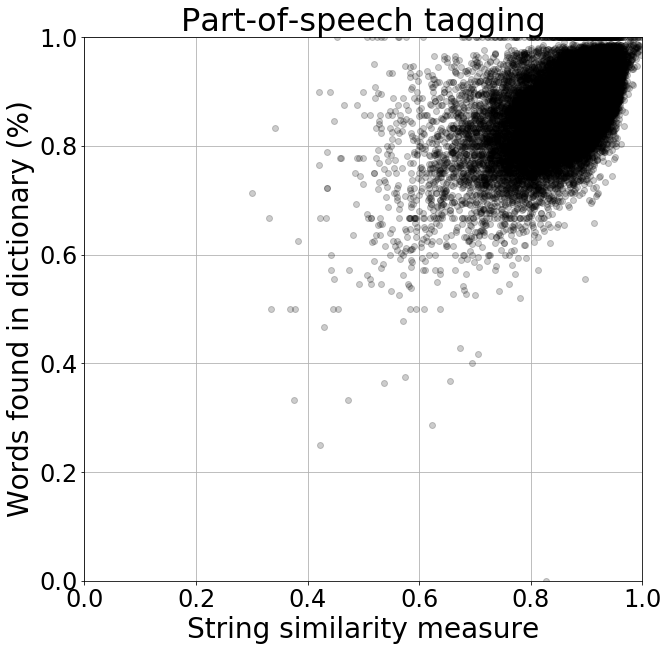

In [15]:
pos_filtered_df = sampledf[~sampledf['postag_acc'].isnull()]
pos_filtered_df = pos_filtered_df[sampledf['postag_acc'] != ""]

plt.figure(figsize=(10, 10))
plt.plot(pos_filtered_df['str_similarity'], pos_filtered_df['postag_acc'], 'ko', alpha=0.2)
plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("String similarity measure", size=28)
plt.ylabel("Words found in dictionary (%)", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.title("Part-of-speech tagging", size=32)
plt.show()

In [16]:
pos_filtered_df = sampledf[~sampledf['postag_acc'].isnull()]
pos_filtered_df = pos_filtered_df[sampledf['postag_acc'] != ""]

/Users/mcollardanuy/anaconda3/envs/allennlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


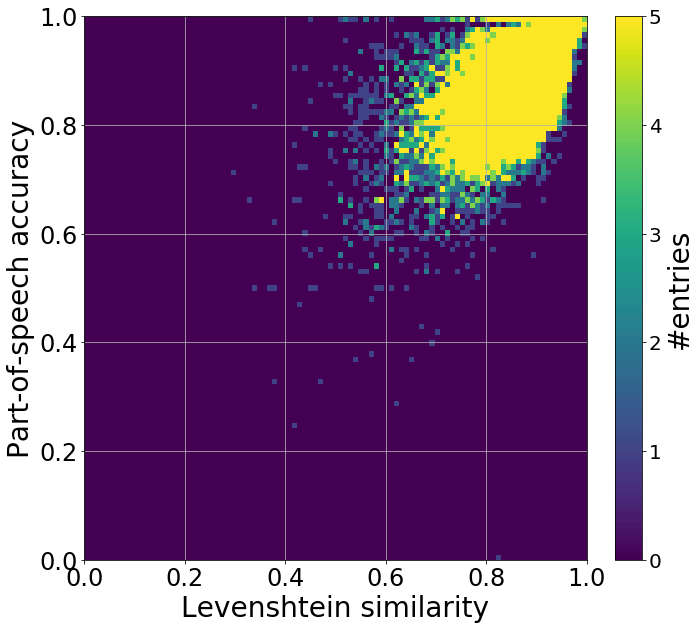

In [17]:
plt.figure(figsize=(10, 10))

xbins = np.linspace(0, 1, 100)
ybins = np.linspace(0, 1, 100)

plt.hist2d(pos_filtered_df['str_similarity'], pos_filtered_df['postag_acc'], 
           bins=[xbins, ybins],
           vmax=5,
           cmap=plt.cm.get_cmap('viridis', 100)
          )
plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("Levenshtein similarity", size=28)
plt.ylabel("Part-of-speech accuracy", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
cbar.set_label('#entries',size=28)
cbar.ax.tick_params(labelsize=20) 
plt.show()

In [23]:
# sampledf.plot(x='str_similarity', y='neriobtype_acc', style='o')
ner_filtered_df = sampledf[~sampledf['neriobtype_acc'].isnull()]
ner_filtered_df = ner_filtered_df[sampledf['neriobtype_acc'] != ""]

/Users/mcollardanuy/anaconda3/envs/allennlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


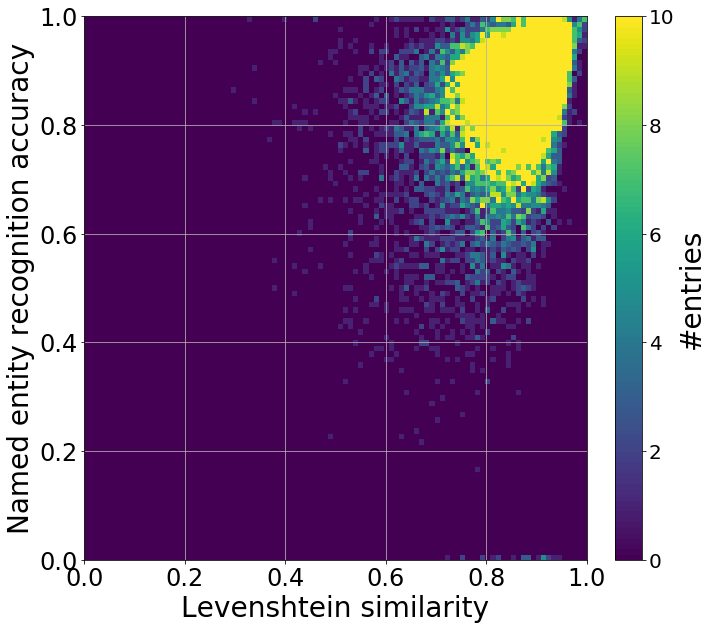

In [32]:
plt.figure(figsize=(10, 10))

xbins = np.linspace(0, 1, 100)
ybins = np.linspace(0, 1, 100)

plt.hist2d(ner_filtered_df['str_similarity'], ner_filtered_df['neriobtype_acc'], 
           bins=[xbins, ybins],
           vmax=10,
           cmap=plt.cm.get_cmap('viridis', 100)
          )
plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("Levenshtein similarity", size=28)
plt.ylabel("Named entity recognition accuracy", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
cbar.set_label('#entries',size=28)
cbar.ax.tick_params(labelsize=20) 
plt.show()

In [30]:
# sampledf.plot(x='str_similarity', y='dependency_parsing', style='o')
dep_filtered_df = sampledf[~sampledf['dependency_parsing'].isnull()]
dep_filtered_df = dep_filtered_df[sampledf['dependency_parsing'] != ""]

/Users/mcollardanuy/anaconda3/envs/allennlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


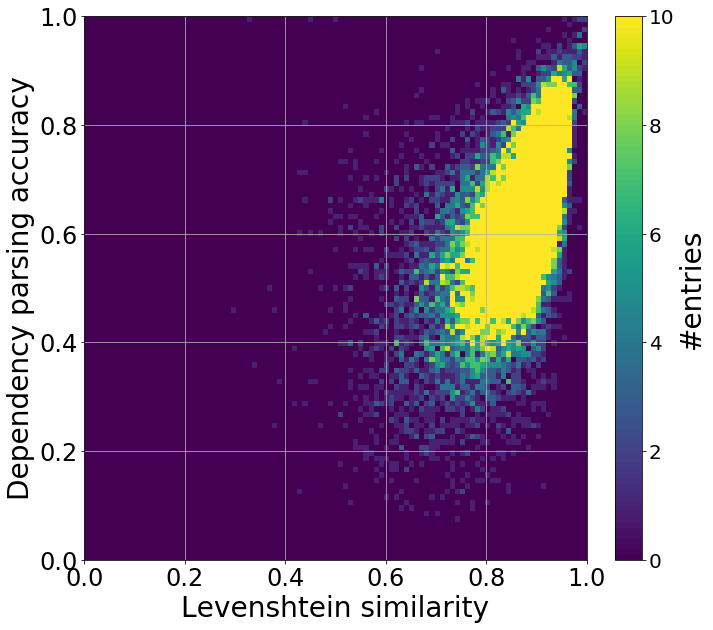

In [33]:
plt.figure(figsize=(10, 10))

xbins = np.linspace(0, 1, 100)
ybins = np.linspace(0, 1, 100)

plt.hist2d(dep_filtered_df['str_similarity'], dep_filtered_df['dependency_parsing'], 
           bins=[xbins, ybins],
           vmax=10,
           cmap=plt.cm.get_cmap('viridis', 100)
          )
plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("Levenshtein similarity", size=28)
plt.ylabel("Dependency parsing accuracy", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
cbar.set_label('#entries',size=28)
cbar.ax.tick_params(labelsize=20) 
plt.show()

In [20]:
sampledf_band1 = sampledf[sampledf['quality_band'] == 1]
sampledf_band2 = sampledf[sampledf['quality_band'] == 2]
sampledf_band3 = sampledf[sampledf['quality_band'] == 3]
sampledf_band4 = sampledf[sampledf['quality_band'] == 4]

In [21]:
dfbands = [sampledf_band1, sampledf_band2, sampledf_band3, sampledf_band4]
for enttype in ['per', 'gpe', 'date']:
    for band in reversed(range(len(dfbands))):
        per_tp = dfbands[band]['ner_' + enttype + '_tp'].sum(axis=0)
        per_fp = dfbands[band]['ner_' + enttype + '_fp'].sum(axis=0)
        per_fn = dfbands[band]['ner_' + enttype + '_fn'].sum(axis=0)

        precision = per_tp / (per_tp + per_fp)
        recall = per_tp / (per_tp + per_fn)
        fscore = (2 * precision * recall) / (precision + recall)
        print("\tBand", str(band + 1) + ":", fscore)

	Band 4: 0.6224559023066486
	Band 3: 0.675522165968026
	Band 2: 0.765638163770769
	Band 1: 0.8464130207797632
	Band 4: 0.5335205335205335
	Band 3: 0.5977587343441002
	Band 2: 0.6831075552322939
	Band 1: 0.7678048145173543
	Band 4: 0.5702479338842975
	Band 3: 0.640316951231016
	Band 2: 0.7224202664787128
	Band 1: 0.8148585550416078


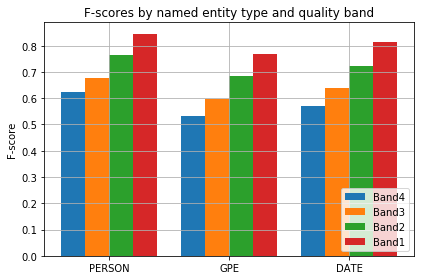

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['per', 'gpe', 'date']

bands_fscores = []
for band in reversed(range(len(dfbands))):
    entityfscores = []
    for enttype in labels:
        per_tp = dfbands[band]['ner_' + enttype + '_tp'].sum(axis=0)
        per_fp = dfbands[band]['ner_' + enttype + '_fp'].sum(axis=0)
        per_fn = dfbands[band]['ner_' + enttype + '_fn'].sum(axis=0)

        precision = per_tp / (per_tp + per_fp)
        recall = per_tp / (per_tp + per_fn)
        fscore = (2 * precision * recall) / (precision + recall)
        entityfscores.append(fscore)
#         print(fscore)
    bands_fscores.append(entityfscores)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.30, bands_fscores[0], width, label='Band4')
rects2 = ax.bar(x - 0.10, bands_fscores[1], width, label='Band3')
rects3 = ax.bar(x + 0.10, bands_fscores[2], width, label='Band2')
rects4 = ax.bar(x + 0.30, bands_fscores[3], width, label='Band1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F-score')
ax.set_title('F-scores by named entity type and quality band')
ax.set_xticks(x)
ax.set_xticklabels(['PERSON', 'GPE', 'DATE'])
ax.legend()
plt.legend(loc='lower right')

fig.tight_layout()
plt.grid()
plt.show()